# CIFAR-10 с трюками

В этом задании мы продолжим работать с CIFAR-10, опробовав трюки, про которые мы узнали в 4 модуле.

Датасет CIFAR-10 состоит из цветных картинок 32x32, разделенных на 10 классов:

__airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck__

# Импорты

In [2]:
!pip install -q tensorflow==2.11

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 72.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 67.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 110.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 kB 42.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 98.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 67.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-datasets 4.9.3 requires protobuf>=3.20, but you have protobuf 3.19.6 which is incompatible.
tensorflow-metadata 1.14.0 requires protobuf<4.21,>=3.20.3, but you have protobuf 3.19.6 which is incompatible.


In [5]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.models as M
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
print(tf.__version__)
print(keras.__version__)

2.11.0
2.11.0


# Загружаем данные

In [3]:
from tensorflow.keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 15s 0us/step


In [4]:
print("Трейн:", x_train.shape, y_train.shape)
print("Тест:", x_test.shape, y_test.shape)

Трейн: (50000, 32, 32, 3) (50000, 1)
Тест: (10000, 32, 32, 3) (10000, 1)


In [6]:
NUM_CLASSES = 10
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer",
                   "dog", "frog", "horse", "ship", "truck"]

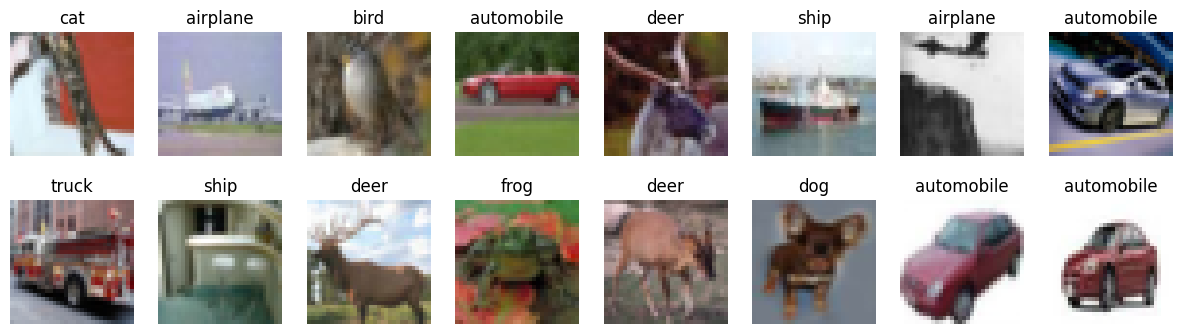

In [7]:
# посмотрим на примеры картинок
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_train))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_train[random_index, :])
        ax.set_title(cifar10_classes[y_train[random_index, 0]])
plt.show()

# Готовим данные

Не забудьте нормализовать картинки: $$x_{norm} = \frac{x}{255} - 0.5$$

А еще нужно превратить метки в one-hot вектора при помощи __keras.utils.to_categorical__.

In [8]:
# нормализуем входы
x_train2 = x_train.astype('float32') / 255 - 0.5
x_test2 = x_test.astype('float32') / 255 - 0.5

# конвертируем метки в np.array (?, NUM_CLASSES)
y_train2 = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test2 = keras.utils.to_categorical(y_test, NUM_CLASSES)

# Задаем *дефолтную* архитектуру сети

In [9]:
# слои, которые нам пригодятся
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

Нам понадобятся такие слои:
- [Conv2D](https://keras.io/layers/convolutional/#conv2d) - сверточный слой:
    - **filters**: количество фильтров на выходе;
    - **kernel_size**: размер скользящего окна;
    - **padding**: padding="same" добивает нулями, чтобы ширина и высота на выходе не изменились, padding='valid' берет только окна, которые полностью помещаются в картинке;
    - **activation**: "relu", "tanh", итд;
    - **input_shape**: размер входа вида (W, H, C_in).
- [MaxPooling2D](https://keras.io/layers/pooling/#maxpooling2d) - пулинг
- [Flatten](https://keras.io/layers/core/#flatten) - все оси, кроме батча (первой) вытягиваются в один вектор.
- [Dense](https://keras.io/layers/core/#dense) - плотный, активацию можно задать через activation="elu" или activation="softmax".
- [Dropout](https://keras.io/layers/core/#dropout) - дропаут регуляризация (без нее сеть сильно переобучается), позже узнаем какой у нее смысл.

Ваша модель должна принимать на вход цветную картинку __(None, 32, 32, 3)__ и предсказывать вероятности 10 классов __(None, 10)__.

Добавьте __4__ сверточных слоя с окном __(3, 3)__ с нарастающим количеством фильтров: __(16, 32, 32, 64)__, используйте "same" паддинг.

Добавьте __2x2__ макс пулинг после каждых 2 сверточных слоев (conv-conv-pool схема).

Используйте __activation='relu'__ для всех слоев, где это нужно.

Добавьте плотный слой из __256__ нейронов и еще один из __10__ нейронов для предсказания выходов. Не забудьте применить __Flatten__ перед первым плотным слоем!

Для регуляризации сети вставьте Dropout после каждого пулинг слоя (с параметром** 0.25**) и между плотными слоями на выходе (с параметром **0.5**).

В дальнейшем будем называть эту архитектуру **дефолтной** и будем исследовать небольшие изменения в ней!

In [36]:
def make_default_model():
    model = Sequential()
    model.add(Conv2D(16, kernel_size=(3,3), padding='same', input_shape=(32, 32, 3)))
    model.add(Conv2D(32, kernel_size=(3,3), padding='same'))
    model.add(MaxPooling2D())
    model.add(Dropout(rate=0.25))
    model.add(Conv2D(32, kernel_size=(3,3), padding='same'))
    model.add(Conv2D(64, kernel_size=(3,3), padding='same'))
    model.add(MaxPooling2D())
    model.add(Dropout(rate=0.25))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(10, activation='softmax'))

    return model

In [37]:
K.clear_session()
model = make_default_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 16)        448       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 16, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 32)        9248      
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 64)        18496     
                                                        

# Тренируем модель

In [38]:
def train_model(make_model_func=make_default_model, optimizer="adam"):
  BATCH_SIZE = 32
  EPOCHS = 10

  K.clear_session()
  model = make_model_func()

  model.compile(
      loss='categorical_crossentropy',
      optimizer=optimizer,
      metrics=['accuracy']
  )

  model.fit(
      x_train2, y_train2,  # нормализованные данные
      batch_size=BATCH_SIZE,
      epochs=EPOCHS,
      validation_data=(x_test2, y_test2),
      shuffle=False
  )

  return model

Давайте посмотрим, что будет с дефолтной моделью (модель = make_default_model, оптимайзер = "adam"), если ее немного поменять:


Часть 1 :
1.   Какое качество (accuracy) на валидации дает **дефолтная архитектура**?

```
Epoch 10/10
1563/1563 [==============================] - 11s 7ms/step - loss: 0.7399 - accuracy: 0.7396 - val_loss: 0.8824 - val_accuracy: 0.7264
<keras.engine.sequential.Sequential at 0x7c5cb1d67ac0>
```


Часть 2:
2.   Измените в дефолтной архитектуре **relu активацию на sigmoid**, какое качество на валидации получили?
```
Epoch 10/10
1563/1563 [==============================] - 10s 6ms/step - loss: 1.0569 - accuracy: 0.6293 - val_loss: 0.9480 - val_accuracy: 0.6690
<keras.engine.sequential.Sequential at 0x7c5cb01361d0>
```

3.   Измените в дефолтной архитектуре **adam оптимайзер на sgd**, какое качество на валидации получили?
```
Epoch 10/10
1563/1563 [==============================] - 13s 8ms/step - loss: 0.9554 - accuracy: 0.6631 - val_loss: 0.9077 - val_accuracy: 0.6871
<keras.engine.sequential.Sequential at 0x7c5c629eefb0>
```

4.   Добавьте к дефолтной архитектуре **батч нормализацию** после каждого сверточного слоя и после первого полносвязного (model.add(BatchNormalization())), какое качество на валидации получили?

```
Epoch 10/10
1563/1563 [==============================] - 14s 9ms/step - loss: 0.8051 - accuracy: 0.7192 - val_loss: 0.8112 - val_accuracy: 0.7294
<keras.engine.sequential.Sequential at 0x7c5c38390490>
```


5.   Добавьте к дефолтной архитектуре **батч нормализацию** и смените **relu активацию на sigmoid**,  какое качество на валидации получили?


```
Epoch 10/10
1563/1563 [==============================] - 14s 9ms/step - loss: 0.8797 - accuracy: 0.6934 - val_loss: 0.8420 - val_accuracy: 0.7103
<keras.engine.sequential.Sequential at 0x7c5c38229ff0>
```
  
*Рекомендуется завести свою функцию для каждого изменения архитектуры!*


In [39]:
# учим дефолтную архитектуру
train_model()

Epoch 1/10
1563/1563 [==============================] - 13s 6ms/step - loss: 1.3484 - accuracy: 0.5242 - val_loss: 1.0254 - val_accuracy: 0.6458
Epoch 2/10
1563/1563 [==============================] - 11s 7ms/step - loss: 1.0513 - accuracy: 0.6338 - val_loss: 0.9696 - val_accuracy: 0.6662
Epoch 3/10
1563/1563 [==============================] - 11s 7ms/step - loss: 0.9671 - accuracy: 0.6653 - val_loss: 0.9898 - val_accuracy: 0.6649
Epoch 4/10
1563/1563 [==============================] - 9s 6ms/step - loss: 0.9055 - accuracy: 0.6866 - val_loss: 0.8866 - val_accuracy: 0.7012
Epoch 5/10
1563/1563 [==============================] - 11s 7ms/step - loss: 0.8570 - accuracy: 0.7031 - val_loss: 0.8887 - val_accuracy: 0.7028
Epoch 6/10
1563/1563 [==============================] - 11s 7ms/step - loss: 0.8292 - accuracy: 0.7107 - val_loss: 0.8698 - val_accuracy: 0.7114
Epoch 7/10
1563/1563 [==============================] - 9s 6ms/step - loss: 0.7896 - accuracy: 0.7259 - val_loss: 0.8034 - val_accu

In [40]:
def make_sigmoid_model():
    model = Sequential()
    model.add(Conv2D(16, kernel_size=(3,3), padding='same', input_shape=(32, 32, 3)))
    model.add(Conv2D(32, kernel_size=(3,3), padding='same'))
    model.add(MaxPooling2D())
    model.add(Dropout(rate=0.25))
    model.add(Conv2D(32, kernel_size=(3,3), padding='same'))
    model.add(Conv2D(64, kernel_size=(3,3), padding='same'))
    model.add(MaxPooling2D())
    model.add(Dropout(rate=0.25))
    model.add(Flatten())
    model.add(Dense(256, activation='sigmoid'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(10, activation='softmax'))

    return model


In [41]:
# учим sigmoid
train_model(make_sigmoid_model)

Epoch 1/10
1563/1563 [==============================] - 14s 7ms/step - loss: 1.4508 - accuracy: 0.4850 - val_loss: 1.0853 - val_accuracy: 0.6262
Epoch 2/10
1563/1563 [==============================] - 11s 7ms/step - loss: 1.1253 - accuracy: 0.6048 - val_loss: 1.0038 - val_accuracy: 0.6494
Epoch 3/10
1563/1563 [==============================] - 10s 6ms/step - loss: 1.0494 - accuracy: 0.6319 - val_loss: 0.9397 - val_accuracy: 0.6726
Epoch 4/10
1563/1563 [==============================] - 11s 7ms/step - loss: 1.0256 - accuracy: 0.6403 - val_loss: 0.9607 - val_accuracy: 0.6646
Epoch 5/10
1563/1563 [==============================] - 11s 7ms/step - loss: 1.0291 - accuracy: 0.6394 - val_loss: 0.9192 - val_accuracy: 0.6769
Epoch 6/10
1563/1563 [==============================] - 9s 6ms/step - loss: 1.0292 - accuracy: 0.6402 - val_loss: 0.9616 - val_accuracy: 0.6619
Epoch 7/10
1563/1563 [==============================] - 11s 7ms/step - loss: 1.0455 - accuracy: 0.6342 - val_loss: 0.9581 - val_acc

In [42]:
# учим sgd
train_model(optimizer="sgd")

Epoch 1/10
1563/1563 [==============================] - 12s 7ms/step - loss: 1.8237 - accuracy: 0.3451 - val_loss: 1.5317 - val_accuracy: 0.4644
Epoch 2/10
1563/1563 [==============================] - 9s 6ms/step - loss: 1.5216 - accuracy: 0.4599 - val_loss: 1.3430 - val_accuracy: 0.5214
Epoch 3/10
1563/1563 [==============================] - 11s 7ms/step - loss: 1.3635 - accuracy: 0.5176 - val_loss: 1.2121 - val_accuracy: 0.5659
Epoch 4/10
1563/1563 [==============================] - 10s 7ms/step - loss: 1.2597 - accuracy: 0.5546 - val_loss: 1.0992 - val_accuracy: 0.6095
Epoch 5/10
1563/1563 [==============================] - 10s 6ms/step - loss: 1.1740 - accuracy: 0.5840 - val_loss: 1.0949 - val_accuracy: 0.6170
Epoch 6/10
1563/1563 [==============================] - 11s 7ms/step - loss: 1.1130 - accuracy: 0.6081 - val_loss: 1.0898 - val_accuracy: 0.6223
Epoch 7/10
1563/1563 [==============================] - 10s 6ms/step - loss: 1.0637 - accuracy: 0.6253 - val_loss: 0.9670 - val_acc

In [43]:
def make_bn_model():
    model = Sequential()
    model.add(Conv2D(16, kernel_size=(3,3), padding='same', input_shape=(32, 32, 3)))
    model.add(BatchNormalization())
    model.add(Conv2D(32, kernel_size=(3,3), padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D())
    model.add(Dropout(rate=0.25))
    model.add(Conv2D(32, kernel_size=(3,3), padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, kernel_size=(3,3), padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D())
    model.add(Dropout(rate=0.25))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(rate=0.5))
    model.add(Dense(10, activation='softmax'))

    return model


In [44]:
# учим bn
train_model(make_bn_model)

Epoch 1/10
1563/1563 [==============================] - 19s 9ms/step - loss: 1.4949 - accuracy: 0.4863 - val_loss: 1.2604 - val_accuracy: 0.5727
Epoch 2/10
1563/1563 [==============================] - 13s 8ms/step - loss: 1.1496 - accuracy: 0.6011 - val_loss: 1.0929 - val_accuracy: 0.6422
Epoch 3/10
1563/1563 [==============================] - 13s 8ms/step - loss: 1.0648 - accuracy: 0.6309 - val_loss: 0.9932 - val_accuracy: 0.6740
Epoch 4/10
1563/1563 [==============================] - 14s 9ms/step - loss: 1.0098 - accuracy: 0.6507 - val_loss: 0.9714 - val_accuracy: 0.6868
Epoch 5/10
1563/1563 [==============================] - 14s 9ms/step - loss: 0.9762 - accuracy: 0.6630 - val_loss: 0.8846 - val_accuracy: 0.6957
Epoch 6/10
1563/1563 [==============================] - 14s 9ms/step - loss: 0.9301 - accuracy: 0.6762 - val_loss: 1.0424 - val_accuracy: 0.6788
Epoch 7/10
1563/1563 [==============================] - 14s 9ms/step - loss: 0.8924 - accuracy: 0.6903 - val_loss: 0.8674 - val_ac

In [45]:
def make_sigmoid_bn_model():
    model = Sequential()
    model.add(Conv2D(16, kernel_size=(3,3), padding='same', input_shape=(32, 32, 3)))
    model.add(BatchNormalization())
    model.add(Conv2D(32, kernel_size=(3,3), padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D())
    model.add(Dropout(rate=0.25))
    model.add(Conv2D(32, kernel_size=(3,3), padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, kernel_size=(3,3), padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D())
    model.add(Dropout(rate=0.25))
    model.add(Flatten())
    model.add(Dense(256, activation='sigmoid'))
    model.add(BatchNormalization())
    model.add(Dropout(rate=0.5))
    model.add(Dense(10, activation='softmax'))

    return model

In [46]:
# учим sigmoid + bn
train_model(make_sigmoid_bn_model)

Epoch 1/10
1563/1563 [==============================] - 18s 9ms/step - loss: 1.5654 - accuracy: 0.4513 - val_loss: 1.6270 - val_accuracy: 0.5105
Epoch 2/10
1563/1563 [==============================] - 13s 9ms/step - loss: 1.2183 - accuracy: 0.5735 - val_loss: 1.0553 - val_accuracy: 0.6360
Epoch 3/10
1563/1563 [==============================] - 15s 9ms/step - loss: 1.1232 - accuracy: 0.6073 - val_loss: 0.9432 - val_accuracy: 0.6715
Epoch 4/10
1563/1563 [==============================] - 15s 10ms/step - loss: 1.0591 - accuracy: 0.6288 - val_loss: 0.9222 - val_accuracy: 0.6788
Epoch 5/10
1563/1563 [==============================] - 16s 10ms/step - loss: 1.0122 - accuracy: 0.6453 - val_loss: 0.9177 - val_accuracy: 0.6847
Epoch 6/10
1563/1563 [==============================] - 15s 10ms/step - loss: 0.9821 - accuracy: 0.6585 - val_loss: 0.8819 - val_accuracy: 0.6929
Epoch 7/10
1563/1563 [==============================] - 15s 9ms/step - loss: 0.9377 - accuracy: 0.6735 - val_loss: 0.8682 - val